# Classification of comments in online store.


Online store is launching a new service where users can edit and enhance product descriptions, similar to wiki communities. Customers suggest edits and comment on others' changes. The store needs a tool to detect toxic comments and send them for moderation.

**Task:** Train a model to classify comments as positive or negative.

**Data Description:** Text comments with toxicity labels.

## Data preparation.

### Data exploration.

#### Importing necessary libraries.

In [3]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from tqdm import tqdm
from wordcloud import WordCloud
from sklearn.pipeline import Pipeline

#### Reviewing the comments labeling file.

##### Opening comments labeling file and saving it in a variable.

In [4]:
from google.colab import files
uploaded = files.upload()

Saving toxic_comments.csv to toxic_comments (1).csv


In [5]:
data = pd.read_csv("toxic_comments.csv", index_col=0)

##### Displaying the first 5 rows of the file.

In [6]:
data.sample(5)

,text,toxic
85961,Block follow-up \n\nThis sort of thing happens...,0
33591,Recreating deleted content\nPlease do not recr...,0
100835,Notrhbysouthbanof sucks cocks \nNotrhbysouthba...,1
12589,There are no examples in the article. \n\nTher...,0
65617,"(UTC)\n\nHi, one note about the range image. I...",0


#####  Displaying basic information on dataset using the info() method.

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


#####  Checking the class balance.

In [8]:
# Counting the number of values in the target variable
class_counts = data['toxic'].value_counts()
print(class_counts)

0    143106
1     16186
Name: toxic, dtype: int64


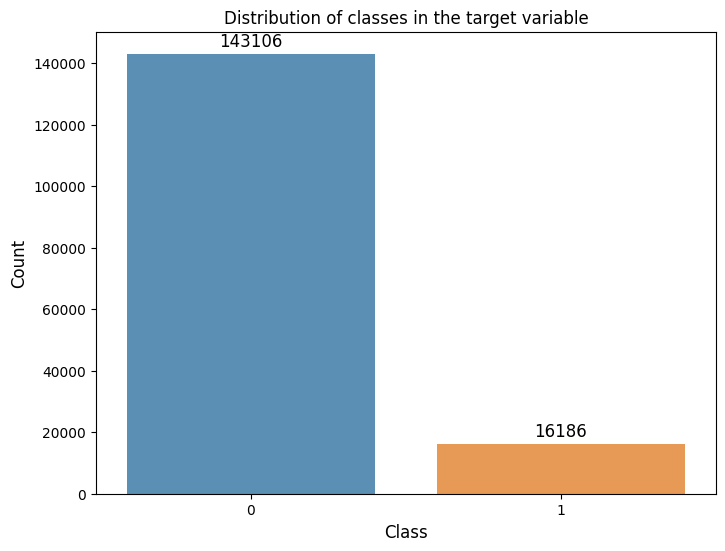

In [9]:
# Plotting the distribution of classes in the target variable
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=class_counts.index, y=class_counts.values, alpha=0.8)
plt.title('Distribution of classes in the target variable')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Class', fontsize=12)

# Adding counts above the bars
for p, label in zip(ax.patches, class_counts.values):
    ax.annotate(label, (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center',
                 xytext=(0, 9),
                 textcoords='offset points', fontsize=12)

plt.show()

The dataset is unbalanced with the number of negative comments being nearly 10 times smaller than the number of positive comments.

### Data preprocessing.

#### Cleaning the text from unnecessary symbols.

In [10]:
%%time
SPACES = r'([ ])\1+'
DOTS = r'[.]+'
SINGLE_WORD_IN_BRACKETS = r'\(.*?\)'
SPECIAL_CHARACTERS_IN_WORDS = r'\S*[:#]\S*'
IP_ADDRESSES = r'\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b'
DATE_TIME = r'\b(?:January|February|March|April|May|June|July|August|September|October|November|December)\s+\d{1,2}\b'
SINGLE_WORD_IN_BRACKETS = r'\(\w+\)'
UTC = r'\bUTC\b'
COMMA_BETWEEN_SPACES = r'\s,\s'
LETTERS = r'[^a-zA-Z\' ]'

def clean_text(text):
    txt = re.sub(IP_ADDRESSES, ' ', text)
    txt = re.sub(SINGLE_WORD_IN_BRACKETS, ' ', txt)
    txt = re.sub(DATE_TIME, ' ', txt)
    txt = re.sub(SPECIAL_CHARACTERS_IN_WORDS, ' ', txt)
    txt = re.sub(LETTERS, ' ', txt)
    txt = re.sub(UTC, ' ', txt)
    txt = re.sub(COMMA_BETWEEN_SPACES, ' ', txt)
    txt = re.sub(SPACES, ' ', txt)
    txt = re.sub(DOTS, '.', txt)
    txt = txt.encode('ascii', 'ignore').decode()
    txt = txt.strip()
    return txt.lower()

# applying tqdm
tqdm.pandas()

data['cleaned_text'] = data['text'].progress_apply(clean_text)

100%|██████████| 159292/159292 [00:23<00:00, 6858.02it/s]

CPU times: user 22.9 s, sys: 22 ms, total: 23 s
Wall time: 23.2 s


Checking the resulting outcome.

In [11]:
print(data['text'][0])

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27


In [12]:
print(data['cleaned_text'][0])

explanation why the edits made under my username hardcore metallica fan were reverted they weren't vandalisms just closure on some gas after i voted at new york dolls fac and please don't remove the template from the talk page since i'm retired now


#### Performing lemmatization and further cleaning of the text from stop words and names. Preparing the text for vectorization.

In [13]:
%%time

# Uploading stop-words and name list
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('names', quiet=True)

CPU times: user 269 ms, sys: 57.4 ms, total: 326 ms
Wall time: 609 ms


True

In [14]:
from nltk.corpus import names

In [15]:
%%time
# Loading SpaCy language model
spacy_model = "en_core_web_sm"
nlp = spacy.load(spacy_model)

CPU times: user 588 ms, sys: 33.8 ms, total: 622 ms
Wall time: 711 ms


In [16]:
%%time

# Combining lists of male and female names and converting them to lowercase
name_list = [name.lower() for name in names.words('male.txt') + names.words('female.txt')]

nlp = spacy.load('en_core_web_sm')

def clean_texts(texts):
    cleaned_texts = []
    for doc in tqdm(nlp.pipe(texts, n_process=-1)):
        txt = [token.lemma_ for token in doc if not token.is_stop and token.lemma_ not in name_list]
        cleaned_text = ' '.join(txt)
        cleaned_texts.append(re.sub(SPACES, r'\1', cleaned_text))
    return cleaned_texts

data['clean_text'] = clean_texts(data['cleaned_text'])

159292it [30:43, 86.43it/s] 

CPU times: user 19min 3s, sys: 7.7 s, total: 19min 11s
Wall time: 30min 43s


In [17]:
print(data['cleaned_text'][0])

explanation why the edits made under my username hardcore metallica fan were reverted they weren't vandalisms just closure on some gas after i voted at new york dolls fac and please don't remove the template from the talk page since i'm retired now


In [18]:
print(data['clean_text'][0])

explanation edit username hardcore metallica revert vandalism closure gas vote new york dolls fac remove template talk retire


In [19]:
print(data['cleaned_text'][1])

d'aww he matches this background colour i'm seemingly stuck with thanks


In [20]:
print(data['clean_text'][1])

d'aww match background colour seemingly stuck thank


In [21]:
data.head()

,text,toxic,cleaned_text,clean_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...,explanation edit username hardcore metallica r...
1,D'aww! He matches this background colour I'm s...,0,d'aww he matches this background colour i'm se...,d'aww match background colour seemingly stuck ...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i'm really not trying to edit war it's...,hey man try edit war constantly remove relevan...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can't make any real suggestions on impr...,real suggestion improvement wonder section sta...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...,sir hero remember


#### Creating and visualizing a word cloud.

In [22]:
%%time
# Data preparation
toxic_comments = data[data['toxic'] == 1]
non_toxic_comments = data[data['toxic'] == 0]

# Combining all comments into one text
toxic_text = ' '.join(toxic_comments['clean_text'])
non_toxic_text = ' '.join(non_toxic_comments['clean_text'])

CPU times: user 117 ms, sys: 19.9 ms, total: 137 ms
Wall time: 149 ms


In [23]:
%%time
# Creating word clouds
toxic_wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(toxic_text)
non_toxic_wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(non_toxic_text)

CPU times: user 7.52 s, sys: 283 ms, total: 7.81 s
Wall time: 7.88 s


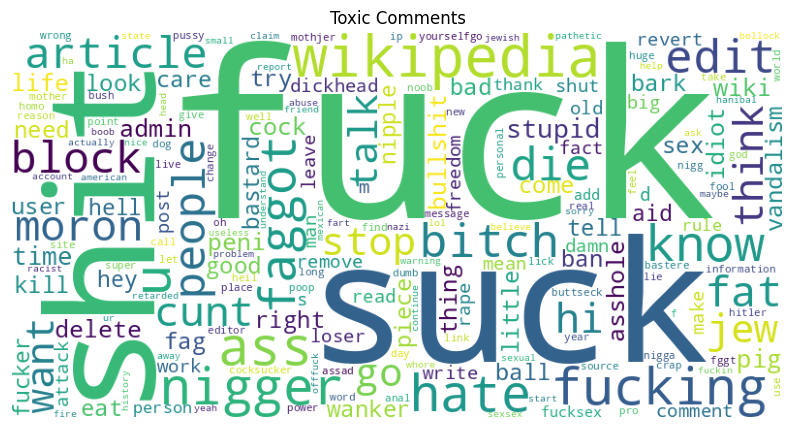

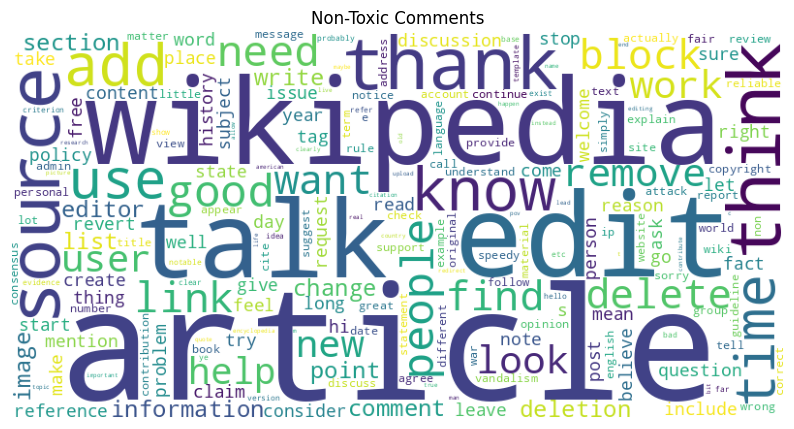

CPU times: user 676 ms, sys: 215 ms, total: 891 ms
Wall time: 682 ms


In [24]:
%%time
# Displaying the word clouds
plt.figure(figsize=(10, 7))
plt.imshow(toxic_wordcloud)
plt.axis('off')
plt.title('Toxic Comments')
plt.show()

plt.figure(figsize=(10, 7))
plt.imshow(non_toxic_wordcloud)
plt.axis('off')
plt.title('Non-Toxic Comments')
plt.show()

#### Removing unnecessary columns.

In [25]:
data = data.drop(columns=['text', 'cleaned_text'])
data.head()

,toxic,clean_text
0,0,explanation edit username hardcore metallica r...
1,0,d'aww match background colour seemingly stuck ...
2,0,hey man try edit war constantly remove relevan...
3,0,real suggestion improvement wonder section sta...
4,0,sir hero remember


#### Splitting the data into training and test sets.

In [26]:
X = data['clean_text']
y = data['toxic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Creating and training models. Evaluating their metrics using cross-validation.

### Creating and training a logistic regression model. Evaluating its metrics using cross-validation.

In [27]:
%%time
# Parameters for grid search
params = {
    'model__C': [0.1, 1, 10, 100],
    'model__penalty': ['l1', 'l2']
}

# Create a pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=40, ngram_range=(1, 4))),
    ('tfidf', TfidfTransformer()),
    ('model', LogisticRegression(max_iter=10000, random_state=42, solver='liblinear'))
])

# Create a grid search object
lr_grid = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=params, scoring='f1')

# Train the model
lr_grid.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters:", lr_grid.best_params_)
print("Best F1 score:", lr_grid.best_score_)

Best parameters: {'model__C': 1, 'model__penalty': 'l1'}
Best F1 score: 0.7630538535646944
CPU times: user 27.5 s, sys: 4.13 s, total: 31.6 s
Wall time: 11min 59s


### Creating and training a Passive-Aggressive classifier model. Evaluating its metrics using cross-validation.

In [28]:
%%time
# Parameters for grid search
params = {
    'model__C': [0.1, 1, 10, 100],
}

# Create a pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=40, ngram_range=(1, 4))),
    ('tfidf', TfidfTransformer()),
    ('model', PassiveAggressiveClassifier(max_iter=1000, random_state=42))
])

# Create a grid search object
pac_grid = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=params, scoring='f1')

# Train the model
pac_grid.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters:", pac_grid.best_params_)
print("Best F1 score:", pac_grid.best_score_)

Best parameters: {'model__C': 0.1}
Best F1 score: 0.7650510661721319
CPU times: user 23.7 s, sys: 2.74 s, total: 26.5 s
Wall time: 5min 51s


### Creating and training a LightGBM model. Evaluating its metrics using cross-validation.

In [29]:
%%time

# Parameters for grid search
params = {
    'model__num_leaves': [31, 127],
    'model__min_data_in_leaf': [50, 100]
}

# Create a pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_df=0.85, min_df=3, ngram_range=(1, 2))),
    ('model', lgb.LGBMClassifier(verbose=-1, seed=42))
])

# Create a grid search object
lgb_grid = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=params, scoring='f1', verbose=-1)

# Train the model
lgb_grid.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters:", lgb_grid.best_params_)
print("Best F1 score:", lgb_grid.best_score_)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'model__min_data_in_leaf': 50, 'model__num_leaves': 127}
Best F1 score: 0.7598747845324664
CPU times: user 2min 14s, sys: 3.32 s, total: 2min 17s
Wall time: 20min 23s


### Selecting optimal classification threshold for the best model.

In [30]:
%%time
# Function to convert probabilities to labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

# Convert scores to probabilities using the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Split the original training data into new training and validation sets
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Train the model on the new training set
pac_grid.fit(X_train_new, y_train_new)

# Get the best threshold on the validation set
yhat = pac_grid.decision_function(X_val)
probs = sigmoid(yhat)
thresholds = np.arange(0, 1, 0.001)
scores = [f1_score(y_val, to_labels(probs, t)) for t in thresholds]
ix = np.argmax(scores)
optimal_threshold = thresholds[ix]

print('Optimal threshold: %.3f, Best F1 score: %.5f' % (optimal_threshold, scores[ix]))

# Save the model with the best hyperparameters and threshold in a variable
best_model = pac_grid.best_estimator_
# Note that we cannot set the threshold directly in the model, so it needs to be applied manually when making predictions

Optimal threshold: 0.414, Best F1 score: 0.78228
CPU times: user 31.7 s, sys: 1.64 s, total: 33.3 s
Wall time: 4min 45s


**Conclusions:**

- All models allowed us to achieve the target metric value.
- The Passive-Aggressive classifier model performed the best among the models.

## Testing best model.

### Evaluation of the best model quality on test dataset.

In [31]:
%%time

# Get scores for the test data
yhat = best_model.decision_function(X_test)
# Convert scores to probabilities
probs = sigmoid(yhat)
# Convert probabilities to labels using the optimal threshold
y_pred = to_labels(probs, optimal_threshold)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred)

print("F1 score on test set:", f1)

F1 score on test set: 0.7703435804701628
CPU times: user 2.5 s, sys: 5.97 ms, total: 2.51 s
Wall time: 2.51 s


### Identifying keywords for classification using the best model.

In [32]:
# Getting the list of words used in the vectorizer
words = best_model.named_steps['vect'].get_feature_names_out()

In [33]:
# Getting the weights used in the model
weights = best_model.named_steps['model'].coef_[0]

In [34]:
# Creating a DataFrame from words and weights and sorting it by weights
df = pd.DataFrame({'Words': words, 'Weight': weights})
df = df.sort_values(by='Weight', ascending=False)

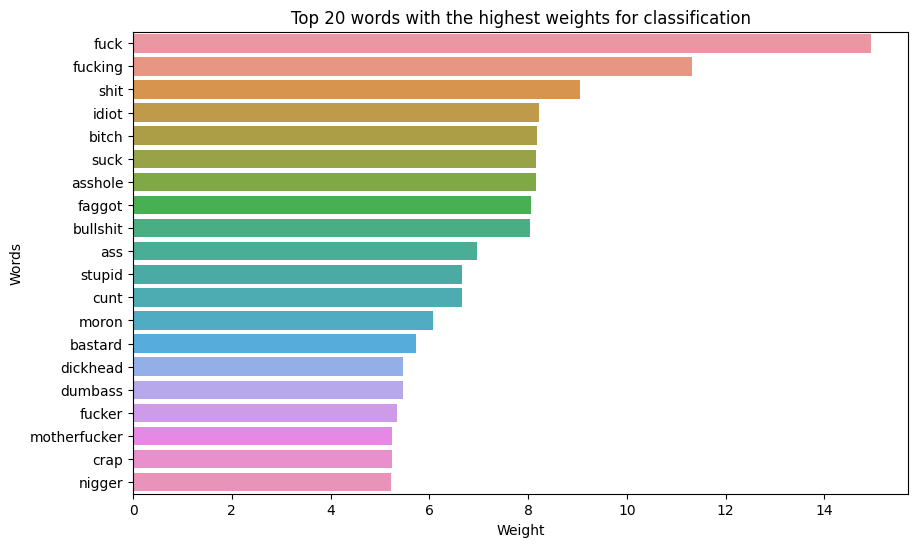

In [35]:
# Visualizing the top 20 words with the highest weights
plt.figure(figsize=(10, 6))
sns.barplot(x='Weight', y='Words', data=df.head(20))
plt.title('Top 20 words with the highest weights for classification')
plt.show()

## Project summary.

For the project, a dataset consisting of nearly 160,000 rows and two columns was provided: one containing text comments and the other containing labels indicating their toxicity. The dataset was imbalanced, with almost 10 times fewer toxic comments than non-toxic ones.

After familiarizing ourselves with the data, we performed data preprocessing, which consisted of the following steps:

- Cleaning the text by removing unnecessary characters using regular expressions.
- Lemmatizing the text using the SpaCy library with a pipeline and removing stopwords and names using the NLTK library.
After cleaning the text, we created word cloud visualizations for each class of comments.

Next, using GridSearchCV and its built-in pipelines, we trained three models while searching for optimal hyperparameters: logistic regression, Passive-Aggressive classifier, and LightGBM. Each model with its optimal hyperparameters allowed us to achieve the target F1 metric. However, adding class weighting significantly reduced the F1 metric. The Passive-Aggressive classifier performed slightly better than the other models. Further tuning of the classification threshold helped improve the F1 metric for the best model.

The best model's effectiveness was confirmed on the test data.

Lastly, we identified and visualized the top 20 words with the highest weights for classifying comments as toxic. As expected, these words mostly consisted of explicit and offensive language.